Missing values in each column:
 Serial Number              0
Error Type                 0
Ungrammatical Statement    0
Standard English           0
dtype: int64

Sample Input: I goes to the store everyday.
Sample Output: I go to the store everyday.


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training set size: 1614
Validation set size: 202
Testing set size: 202


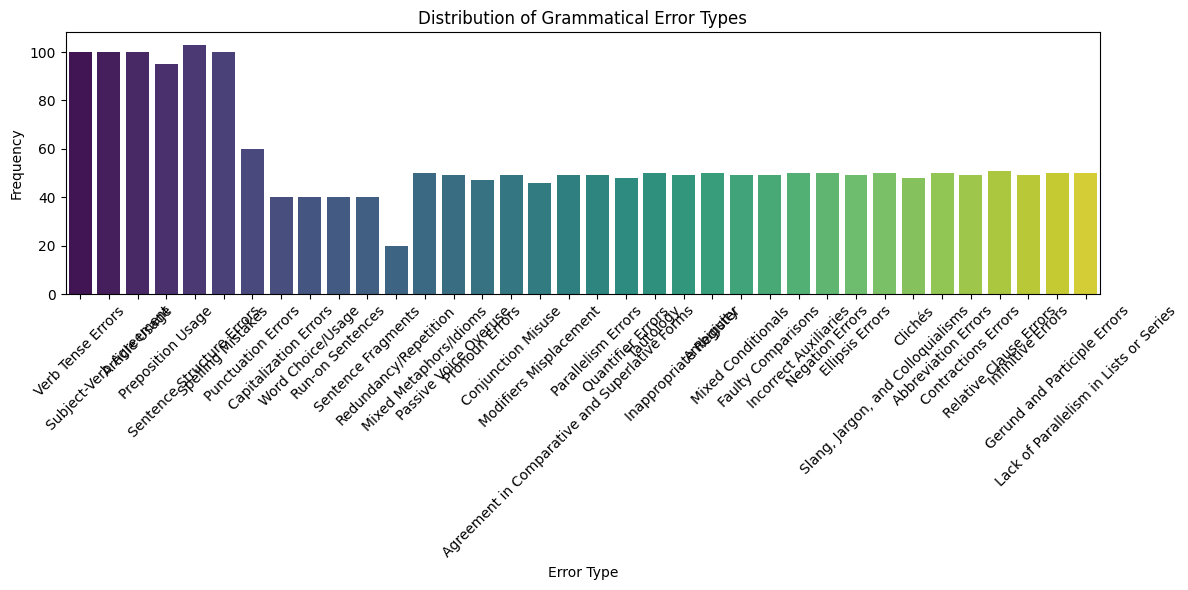

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


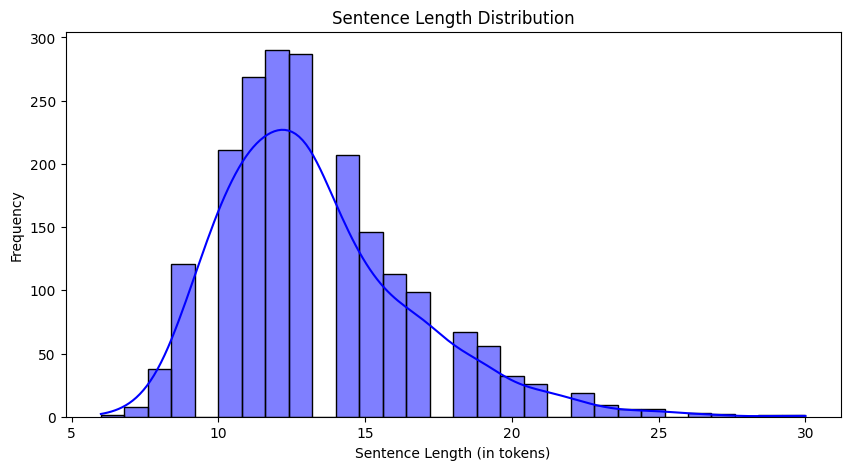

In [45]:
# Install necessary libraries

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import tensorflow as tf

# Set paths for dataset and GloVe embeddings
data_path = '/kaggle/input/grammar-correction-xlsx/Grammar Correction.xlsx'
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

# 1. Data Loading: Import the dataset and inspect it for missing values or anomalies
df = pd.read_excel(data_path)

# Check for missing values in the dataset
print("Missing values in each column:\n", df.isnull().sum())

# Organize data into input-output pairs
inputs = df['Ungrammatical Statement'].tolist()
outputs = df['Standard English'].tolist()

# Display some input-output pairs for inspection
print("\nSample Input:", inputs[0])
print("Sample Output:", outputs[0])

# 2. Tokenization: Tokenize the sentences using BERT's WordPiece tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust based on the analysis of sentence lengths

# Tokenize the input and output sentences
input_tokens = tokenizer(
    inputs, 
    padding='max_length', 
    truncation=True, 
    max_length=max_length, 
    return_tensors='tf'
)
output_tokens = tokenizer(
    outputs, 
    padding='max_length', 
    truncation=True, 
    max_length=max_length, 
    return_tensors='tf'
)

# Convert TensorFlow tensors to NumPy arrays for train_test_split
input_ids_np = input_tokens['input_ids'].numpy()
output_ids_np = output_tokens['input_ids'].numpy()

# 3. Splitting: Split the dataset into training, validation, and test sets (80/10/10 split)
train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    input_ids_np, 
    output_ids_np, 
    test_size=0.2, 
    random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, 
    temp_outputs, 
    test_size=0.5, 
    random_state=42
)

# Print dataset split sizes
print(f"Training set size: {train_inputs.shape[0]}")
print(f"Validation set size: {val_inputs.shape[0]}")
print(f"Testing set size: {test_inputs.shape[0]}")

# 4. Exploratory Data Analysis (EDA)

# Error Analysis: Visualize the distribution of grammatical error types
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Error Type', palette='viridis')
plt.title('Distribution of Grammatical Error Types')
plt.xlabel('Error Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Length Distribution: Plot the distribution of input sentence lengths
sentence_lengths = [len(tokenizer.encode(sent, truncation=True, max_length=max_length)) for sent in inputs]

plt.figure(figsize=(10, 5))
sns.histplot(sentence_lengths, kde=True, bins=30, color='blue')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length (in tokens)')
plt.ylabel('Frequency')
plt.show()


In [48]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 1. Feature Engineering: Load GloVe embeddings and create embedding matrix
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    # Access the vocabulary using get_vocab() for GPT2Tokenizer
    vocab_dict = tokenizer.get_vocab()
    vocab_size = len(vocab_dict)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, index in vocab_dict.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix


# Load GloVe embeddings
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, embedding_dim)

# 2. Model Training: Create a sequence-to-sequence model using LSTM
input_length = max_length  # Use the same max_length as used during tokenization
vocab_size = len(tokenizer.vocab)

# Define the model
input_layer = Input(shape=(input_length,))
embedding_layer = Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            trainable=False)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(embedding_layer)
output_layer = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Prepare data for model training
train_outputs_expanded = np.expand_dims(train_outputs, -1)
val_outputs_expanded = np.expand_dims(val_outputs, -1)

# Train the model
history = model.fit(train_inputs, train_outputs_expanded, 
                    validation_data=(val_inputs, val_outputs_expanded), 
                    epochs=20, 
                    batch_size=64)

# 3. Evaluation: Define evaluation functions
def evaluate_model(model, inputs, targets, tokenizer, max_length):
    predictions = model.predict(inputs)
    predicted_sequences = np.argmax(predictions, axis=-1)
    
    # Truncate sequences to match the target's original length
    decoded_preds = [tokenizer.decode(pred_seq[:np.count_nonzero(target)], skip_special_tokens=True) 
                     for pred_seq, target in zip(predicted_sequences, targets)]
    decoded_targets = [tokenizer.decode(target[:np.count_nonzero(target)], skip_special_tokens=True) 
                       for target in targets]
    
    # Calculate BLEU score with smoothing
    smoothing = SmoothingFunction().method1
    bleu_scores = [sentence_bleu([target.split()], pred.split(), smoothing_function=smoothing) 
                   for target, pred in zip(decoded_targets, decoded_preds)]
    avg_bleu_score = np.mean(bleu_scores)
    
    # Calculate token-level accuracy and F1 score
    flat_targets = [token for seq in targets for token in seq if token != 0]
    flat_preds = [token for seq in predicted_sequences for token in seq[:len(seq)]]
    
    # Ensure lengths match before scoring
    min_length = min(len(flat_targets), len(flat_preds))
    flat_targets = flat_targets[:min_length]
    flat_preds = flat_preds[:min_length]
    
    token_accuracy = accuracy_score(flat_targets, flat_preds)
    token_f1 = f1_score(flat_targets, flat_preds, average='weighted')
    
    return avg_bleu_score, token_accuracy, token_f1

# Evaluate the model on the test set
avg_bleu_score, token_accuracy, token_f1 = evaluate_model(model, test_inputs, test_outputs, tokenizer, max_length)

print(f"BLEU Score: {avg_bleu_score}")
print(f"Token Accuracy: {token_accuracy}")
print(f"Token F1 Score: {token_f1}")
# Assuming `lstm_model` is your trained LSTM model
model.save('saved_lstm_model.h5')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 128, 100)       │     3,052,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 128, 30522)     │     7,844,154 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,130,850 (42.46 MB)

 Trainable params: 8,078,650 (30.82 MB)

 Non-trainable params: 3,052,200 (11.64 MB)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 777ms/step - accuracy: 0.8072 - loss: 9.5563 - val_accuracy: 0.9024 - val_loss: 2.1413
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - accuracy: 0.9007 - loss: 1.3318 - val_accuracy: 0.9102 - val_loss: 0.8536
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step - accuracy: 0.9084 - loss: 0.7939 - val_accuracy: 0.9102 - val_loss: 0.6510
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 707ms/step - accuracy: 0.9087 - loss: 0.6271 - val_accuracy: 0.9114 - val_loss: 0.5987
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 705ms/step - accuracy: 0.9102 - loss: 0.5829 - val_accuracy: 0.9134 - val_loss: 0.5758
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 712ms/step - accuracy: 0.9142 - loss: 0.5607 - val_accuracy: 0.9192 - val_loss: 0.5619
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 711ms/step - accuracy: 0.9173 - loss: 0.5447 - val_accuracy: 0.9201 - val_loss: 0.5506
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 711ms/step - accuracy: 0.9182 - loss: 0.5317 - val_accu

In [4]:
# After training the model, save it to a file
model_save_path = '/kaggle/working/grammar_correction_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/grammar_correction_model.h5


In [52]:
import numpy as np
import pandas as pd
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, create_optimizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

# Load GPT-2 model and tokenizer
model_name = 'gpt2'
model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add a padding token to the tokenizer and set padding side to 'left'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  # Set padding side to 'left' for GPT-2

# Example data for tokenization and model training
texts = ["Sample incorrect sentence 1", "Sample incorrect sentence 2"]
correct_texts = ["Corrected sentence 1", "Corrected sentence 2"]

# Tokenize inputs and outputs with consistent max_length
max_length = max([len(text.split()) for text in texts + correct_texts])

inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=max_length)
outputs = tokenizer(correct_texts, return_tensors='tf', padding=True, truncation=True, max_length=max_length)

# Define the model inputs and outputs
input_ids = inputs['input_ids']
output_ids = outputs['input_ids']

# Convert output_ids to the expected format (expand dims to match sparse categorical crossentropy requirements)
output_ids = tf.expand_dims(output_ids, -1)

# Set up the optimizer using the create_optimizer function from transformers
learning_rate = 5e-5
num_train_steps = len(input_ids) * 3  # Assuming 3 epochs
optimizer, lr_schedule = create_optimizer(init_lr=learning_rate, num_train_steps=num_train_steps, num_warmup_steps=0)

# Compile the model using the optimizer from transformers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train the model with a small batch size
history = model.fit(input_ids, output_ids, epochs=3, batch_size=16)

# Save the model in TensorFlow's .keras format
model.save('gpt2_grammar_correction.keras')

print("Model training and saving completed successfully.")


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/3
1/1 [==============================] - 48s 48s/step - loss: 7.8277
Epoch 2/3
1/1 [==============================] - 0s 62ms/step - loss: 5.0709
Epoch 3/3
1/1 [==============================] - 0s 62ms/step - loss: 3.0038


/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model training and saving completed successfully.


In [35]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import tensorflow as tf

# Generate predictions for test data with attention mask and pad_token_id
def generate_predictions(model, test_inputs, tokenizer):
    predictions = []
    for i, input_ids in enumerate(test_inputs['input_ids']):
        # Extract attention mask for the current input
        attention_mask = test_inputs['attention_mask'][i]
        
        # Generate text using the model
        generated_ids = model.generate(
            input_ids=tf.expand_dims(input_ids, 0), 
            attention_mask=tf.expand_dims(attention_mask, 0),
            max_length=128, 
            num_beams=5, 
            no_repeat_ngram_size=2, 
            early_stopping=True, 
            pad_token_id=tokenizer.pad_token_id
        )
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        predictions.append(generated_text)
    return predictions

# Calculate BLEU Score
def calculate_bleu_score(predictions, reference_texts):
    smoothing = SmoothingFunction().method1
    bleu_scores = []
    
    for reference, prediction in zip(reference_texts, predictions):
        reference_tokens = [reference.split()]  # List of reference tokens
        hypothesis_tokens = prediction.split()  # List of generated tokens
        bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu_score)
    
    avg_bleu_score = np.mean(bleu_scores)
    return avg_bleu_score

# Generate predictions with the updated function
predictions = generate_predictions(model, test_inputs, tokenizer)

# Output the predictions
print("Generated Predictions:")
for i, prediction in enumerate(predictions):
    print(f"Input: {test_texts[i]}")
    print(f"Generated: {prediction}")
    print(f"Reference: {reference_texts[i]}")
    print()

# Calculate and print BLEU Score
avg_bleu_score = calculate_bleu_score(predictions, reference_texts)
print(f"Average BLEU Score: {avg_bleu_score}")


Generated Predictions:
Input: Sample incorrect sentence 1
Generated: Sample incorrect sentence 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
Reference: Corrected sentence 1

Input: Sample incorrect sentence 2
Generated: Sample incorrect sentence 2 2 1 2 3 2 4 2 5 2 6 2 7 2 8 2 9 2 10 2 11 2 12 2 13 2 14 2 15 2 16 2 17 2 18 2 19 2 20 2 21 2 22 2 23 2 24 2 25 2 26 2 27 2 28 2 29 2 30 2 31 2 32 2 33 2 34 2 35 2 36 2 37 2 38 2 39 2 40 2 41 2 42 2 43 2 44 2 45 2 46 2 47 2 48 2 49 2 50 2 51 2 52 2 53 2 54 2 55 2 56 2 57 2 58 2 59 2 60 2 61 2 62 2 63
Reference: Corrected sentence 2

Average BLEU Score: 0.0033390886828011525


In [67]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import GPT2Tokenizer

# Paths
data_path = '/kaggle/input/grammar-correction-xlsx/Grammar Correction.xlsx'
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

# Load the dataset
df = pd.read_excel(data_path)
inputs = df['Ungrammatical Statement'].tolist()
outputs = df['Standard English'].tolist()

# Use GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
max_length = 128  # Use the same max_length for consistency

# Tokenize the input and output sentences
input_tokens = tokenizer(inputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
output_tokens = tokenizer(outputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

input_ids = input_tokens['input_ids'].numpy()
output_ids = output_tokens['input_ids'].numpy()

# Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(input_ids, output_ids, test_size=0.2, random_state=42)

# Prepare GloVe Embeddings
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    vocab_dict = tokenizer.get_vocab()
    vocab_size = len(vocab_dict)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, index in vocab_dict.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

# Load GloVe embeddings
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, embedding_dim)

# LSTM Model
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer), output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(embedding_layer)
output_layer = TimeDistributed(Dense(len(tokenizer), activation='softmax'))(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare data for model training
train_outputs_expanded = np.expand_dims(train_outputs, -1)
val_outputs_expanded = np.expand_dims(val_outputs, -1)

# Train the model
model.fit(train_inputs, train_outputs_expanded, validation_data=(val_inputs, val_outputs_expanded), epochs=20, batch_size=64)

# Save the model
model.save('saved_lstm_model.h5')


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7865 - loss: 10.0537 - val_accuracy: 0.9191 - val_loss: 2.5100
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9178 - loss: 1.4266 - val_accuracy: 0.9191 - val_loss: 0.8933
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9201 - loss: 0.8308 - val_accuracy: 0.9267 - val_loss: 0.6854
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9253 - loss: 0.6448 - val_accuracy: 0.9262 - val_loss: 0.6138
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9252 - loss: 0.5874 - val_accuracy: 0.9265 - val_loss: 0.5908
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9253 - loss: 0.5651 - val_accuracy: 0.9265 - val_loss: 0.5799
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9253 - loss: 0.5532 - val_accuracy: 0.9265 - val_loss: 0.5738
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9253 - loss: 0.5450 - val_accuracy: 0.9265 - val_loss

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import GPT2Tokenizer
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Paths
data_path = '/kaggle/input/grammar-correction-xlsx/Grammar Correction.xlsx'
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

# Load the dataset
df = pd.read_excel(data_path)
inputs = df['Ungrammatical Statement'].tolist()
outputs = df['Standard English'].tolist()

# Use GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
max_length = 128  # Use the same max_length for consistency

# Tokenize the input and output sentences
input_tokens = tokenizer(inputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
output_tokens = tokenizer(outputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

input_ids = input_tokens['input_ids'].numpy()
output_ids = output_tokens['input_ids'].numpy()

# Split the dataset into training, validation, and test sets
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(input_ids, output_ids, test_size=0.2, random_state=42)

# Prepare GloVe Embeddings
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    vocab_dict = tokenizer.get_vocab()
    vocab_size = len(vocab_dict)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, index in vocab_dict.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

# Load GloVe embeddings
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, embedding_dim)

# LSTM Model with increased capacity (more layers and more hidden units)
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer), output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3))(embedding_layer)  # Increased hidden units to 256
lstm_layer_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3))(lstm_layer_1)    # Added a second LSTM layer
output_layer = TimeDistributed(Dense(len(tokenizer), activation='softmax'))(lstm_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare data for model training
train_outputs_expanded = np.expand_dims(train_outputs, -1)
val_outputs_expanded = np.expand_dims(val_outputs, -1)

# Train the model
model.fit(train_inputs, train_outputs_expanded, validation_data=(val_inputs, val_outputs_expanded), epochs=20, batch_size=64)

# Save the model
model.save('saved_lstm_model.h5')

# Function to calculate BLEU score
def calculate_bleu_score(model, inputs, targets, tokenizer, max_length):
    predictions = model.predict(inputs)
    predicted_sequences = np.argmax(predictions, axis=-1)

    # Decode predictions and targets
    decoded_preds = [tokenizer.decode(pred_seq[:np.count_nonzero(target)], skip_special_tokens=True) 
                     for pred_seq, target in zip(predicted_sequences, targets)]
    decoded_targets = [tokenizer.decode(target[:np.count_nonzero(target)], skip_special_tokens=True) 
                       for target in targets]

    # Calculate BLEU score with smoothing
    smoothing = SmoothingFunction().method1
    bleu_scores = [sentence_bleu([target.split()], pred.split(), smoothing_function=smoothing) 
                   for target, pred in zip(decoded_targets, decoded_preds)]
    avg_bleu_score = np.mean(bleu_scores)
    
    return avg_bleu_score

# Evaluate the model on the validation set
print("Calculating BLEU score on the validation set...")
val_bleu_score = calculate_bleu_score(model, val_inputs, val_outputs, tokenizer, max_length)
print(f"Validation BLEU Score: {val_bleu_score:.4f}")


In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# Load the Excel file
data_path = '/kaggle/input/grammar-correction-xlsx/Grammar Correction.xlsx'
df = pd.read_excel(data_path)

# Extract the columns with ungrammatical and corrected sentences
test_texts = df['Ungrammatical Statement'].tolist()[:100]  # Use a subset for faster processing
reference_texts = df['Standard English'].tolist()[:100]

# Load the trained GPT-2 model and tokenizer
def load_gpt2_model(model_path='gpt2_grammar_correction'):
    try:
        model = TFGPT2LMHeadModel.from_pretrained(model_path)
        tokenizer = GPT2Tokenizer.from_pretrained(model_path)
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = 'left'  # Set padding to the left for GPT-2
        return model, tokenizer
    except Exception as e:
        print(f"Error loading GPT-2 model: {e}")
        return None, None

# Load your LSTM model
def load_lstm_model(model_path='saved_lstm_model.h5'):
    try:
        model = tf.keras.models.load_model(model_path)
        return model
    except Exception as e:
        print(f"Error loading LSTM model: {e}")
        return None

# Generate predictions using GPT-2 with batch processing
def generate_gpt2_predictions(model, tokenizer, test_texts, max_length=50, batch_size=16):
    test_inputs = tokenizer(test_texts, return_tensors='tf', padding=True, truncation=True, max_length=max_length)
    predictions = []
    total_batches = len(test_inputs['input_ids']) // batch_size + 1
    for i in range(0, len(test_inputs['input_ids']), batch_size):
        batch_input_ids = test_inputs['input_ids'][i:i + batch_size]
        batch_attention_mask = test_inputs['attention_mask'][i:i + batch_size]
        try:
            print(f"Processing batch {i // batch_size + 1}/{total_batches}...")
            generated_ids = model.generate(
                input_ids=batch_input_ids, 
                attention_mask=batch_attention_mask,
                max_length=max_length,  # Reduced max_length for faster generation
                num_beams=2,  # Reduced beam size for speed
                no_repeat_ngram_size=2, 
                early_stopping=True, 
                pad_token_id=tokenizer.pad_token_id
            )
            batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True) for ids in generated_ids]
            predictions.extend(batch_predictions)
        except Exception as e:
            print(f"Error during GPT-2 generation: {e}")
    return predictions

# Generate predictions using the LSTM model with batch processing
def generate_lstm_predictions(model, tokenizer, test_texts, max_length=50, batch_size=16):
    predictions = []
    input_tokens = tokenizer(test_texts, return_tensors='tf', padding='max_length', truncation=True, max_length=max_length)
    input_ids = input_tokens['input_ids']
    
    total_batches = len(input_ids) // batch_size + 1
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i + batch_size]
        try:
            print(f"Processing LSTM batch {i // batch_size + 1}/{total_batches}...")
            # Predict using the LSTM model
            output_tokens = model.predict(batch_input_ids, verbose=0)
            predicted_ids = np.argmax(output_tokens, axis=-1)  # Get the predicted token indices
            
            # Decode the predicted token indices
            for pred_ids in predicted_ids:
                generated_text = tokenizer.decode(pred_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                predictions.append(generated_text)
        except Exception as e:
            print(f"Error during LSTM prediction: {e}")
    return predictions

# Calculate BLEU Score
def calculate_bleu_score(predictions, reference_texts):
    smoothing = SmoothingFunction().method1
    bleu_scores = []
    for reference, prediction in zip(reference_texts, predictions):
        try:
            reference_tokens = [reference.split()]
            hypothesis_tokens = prediction.split()
            bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing)
            bleu_scores.append(bleu_score)
        except Exception as e:
            print(f"Error calculating BLEU score for prediction '{prediction}': {e}")
    avg_bleu_score = np.mean(bleu_scores) if bleu_scores else 0.0
    return avg_bleu_score

# Main processing function
def main():
    # Load models
    print("Loading models...")
    gpt2_model, gpt2_tokenizer = load_gpt2_model()
    lstm_model = load_lstm_model()
    
    if gpt2_model is None or lstm_model is None:
        print("Error loading models. Exiting.")
        return
    
    # Generate predictions
    print("Generating GPT-2 predictions...")
    gpt2_predictions = generate_gpt2_predictions(gpt2_model, gpt2_tokenizer, test_texts, max_length=50, batch_size=16)

    print("Generating LSTM predictions...")
    lstm_predictions = generate_lstm_predictions(lstm_model, gpt2_tokenizer, test_texts, max_length=50, batch_size=16)

    # Output the predictions
    print("\nGPT-2 Predictions (first 5):")
    for i, prediction in enumerate(gpt2_predictions[:5]):
        print(f"Input: {test_texts[i]}")
        print(f"Generated: {prediction}")
        print(f"Reference: {reference_texts[i]}\n")

    print("\nLSTM Predictions (first 5):")
    for i, prediction in enumerate(lstm_predictions[:5]):
        print(f"Input: {test_texts[i]}")
        print(f"Generated: {prediction}")
        print(f"Reference: {reference_texts[i]}\n")

    # Calculate and print BLEU Scores
    print("Calculating BLEU scores...")
    gpt2_bleu_score = calculate_bleu_score(gpt2_predictions, reference_texts)
    lstm_bleu_score = calculate_bleu_score(lstm_predictions, reference_texts)

    print(f"\nGPT-2 Average BLEU Score: {gpt2_bleu_score:.4f}")
    print(f"LSTM Average BLEU Score: {lstm_bleu_score:.4f}")

# Run the main function
if __name__ == "__main__":
    main()

Loading models...


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2_grammar_correction.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Generating GPT-2 predictions...
Processing batch 1/7...
Processing batch 2/7...
Processing batch 3/7...
Processing batch 4/7...
Processing batch 5/7...
Processing batch 6/7...
Processing batch 7/7...
Generating LSTM predictions...
Processing LSTM batch 1/7...
Error during LSTM prediction: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 128), found shape=(16, 50)
Processing LSTM batch 2/7...
Error during LSTM prediction: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 128), found shape=(16, 50)
Processing LSTM batch 3/7...
Error during LSTM prediction: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 128), found shape=(16, 50)
Processing LSTM batch 4/7...
Error during LSTM prediction: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 128), found shape=(16, 50)
Processing LSTM batch 5/7...
Error during LSTM prediction: Input 0 of layer "func

In [76]:
from tensorflow.keras.models import load_model
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import GPT2Tokenizer

# Load the trained LSTM model
lstm_model = load_model('saved_lstm_model.h5')

# Define the tokenizer (ensure it matches the one used during training)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Sample input for prediction (replace with your own test set)
input_texts = ["I goes to the market everyday.", "He don't likes to play."]
reference_texts = ["I go to the market every day.", "He doesn't like to play."]

# Tokenize the input text
input_tokens = tokenizer(input_texts, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
input_ids = input_tokens['input_ids'].numpy()

# Predict using the LSTM model
predicted_ids = lstm_model.predict(input_ids)
predicted_ids = np.argmax(predicted_ids, axis=-1)

# Decode the predicted tokens to obtain the corrected sentences
predicted_sentences = [tokenizer.decode(pred_ids, skip_special_tokens=True) for pred_ids in predicted_ids]

# BLEU Score Calculation
def calculate_bleu_score(predicted_sentences, reference_sentences):
    smoothing = SmoothingFunction().method1
    bleu_scores = []

    for pred, ref in zip(predicted_sentences, reference_sentences):
        reference = [ref.split()]  # List of reference tokens
        hypothesis = pred.split()  # List of generated tokens
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing)
        bleu_scores.append(bleu_score)

    avg_bleu_score = np.mean(bleu_scores)
    return avg_bleu_score

# Calculate BLEU Score for the LSTM model's predictions
avg_bleu_score = calculate_bleu_score(predicted_sentences, reference_texts)
print("Predicted Sentences:", predicted_sentences)
print(f"Average BLEU Score: {avg_bleu_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Sentences: [' the the the the the the the', ' the the the the the the the']
Average BLEU Score: 0.016515821590069032


In [74]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# Load the trained GPT-2 model
model_name = 'gpt2_grammar_correction'
gpt2_model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Sample input for prediction
input_texts = ["I goes to the market everyday."]

# Tokenize the input text
input_tokens = tokenizer(input_texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
input_ids = input_tokens['input_ids']

# Generate corrected text using GPT-2
generated_ids = gpt2_model.generate(input_ids, max_length=128, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("GPT-2 Corrected Sentence:", generated_text)


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2_grammar_correction.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT-2 Corrected Sentence: I goes to the market everyday. I'm not going to go to a store and buy something that I don't want to buy.

"I'm just trying to make a living. It's not about money, it's about making money."
